## Train sea lion classifier with a convnet

In [1]:
INPUT_DIR = '../../input/kaggle-sea-lion/02/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/07/'
IMAGE_DIMS = (84,84,3)
#IMAGE_DIMS = (84,84,3)
#IMAGE_DIMS = (56,56,3)
#IMAGE_DIMS = (42,42,3)
#IMAGE_DIMS = (26,26,3)

INPUT_DATASET_NAME = 'lion-patches-0px'
SAVE_WEIGHTS_FILE = OUTPUT_DIR + 'last-weights-medium1-single.h5'
SAVE_MODEL_FILE = None
#SAVE_MODEL_FILE = OUTPUT_DIR + 'last-model-medium1-class0-84x84.yml'
LOAD_WEIGHTS_FILE = SAVE_WEIGHTS_FILE
LOAD_MODEL_FILE = None

RECREATE_OUTPUT_DIR = True
RUN_TRAINING = True

Y_CHANGE = None
#Y_CHANGE = ((1,5),(2,5),(3,5),(4,5))
TRAIN_WEIGHT = (1,0.2,0.2,0.2,0.2,0.2)
TEST_WEIGHT = (1,0.2,0.2,0.2,0.2,0.2)
TRAIN_EPOCHS = 20
INPUT_RANGE = 1

BATCH_SIZE=48

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import models

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions

Using TensorFlow backend.


## Prepare

### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, dirs=['tf-logs','weights'], recreate=RECREATE_OUTPUT_DIR)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
TF_LOGS_DIR = OUTPUT_DIR + 'tf-logs/'
WEIGHTS_DIR = OUTPUT_DIR + 'weights/'
input_dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)

logger.info('Output dirs created')

2017-06-11 01:49:42,735 INFO Output dirs created


### Prepare train, validate and test data flows

In [4]:
logger.info('Using dataset ' + input_dataset_path + ' as input')
h5file = h5py.File(input_dataset_path, 'r')

#used for image augmentation (creating new images for balancing)
image_augmentation_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=359,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        horizontal_flip=True,
        vertical_flip=True)

#applied to all images during training
image_randomize_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=359,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        horizontal_flip=True,
        vertical_flip=True)

def categorical_to_boolean(x, y):
    y2 = [[y1[0]] for y1 in y]
    return x,y2

logger.info('preparing train data')
train_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
train_balance_generator = utils.ClassBalancerGeneratorXY(train_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TRAIN_WEIGHT,
                                                         max_augmentation_ratio=1,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0, end_ratio=0.7,
                                                         change_y=Y_CHANGE)
train_image_generator = utils.ImageAugmentationXYGenerator(train_balance_generator, image_randomize_generator)
train_generator = utils.ChangeXYGenerator(train_image_generator, categorical_to_boolean)

logger.info('train size=' + str(train_balance_generator.size) + ' batches=' + str(train_balance_generator.nr_batches))


logger.info('preparing valid data')
valid_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
valid_balance_generator = utils.ClassBalancerGeneratorXY(valid_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TEST_WEIGHT,
                                                         max_augmentation_ratio=1,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0.7, end_ratio=0.85,
                                                         change_y=Y_CHANGE)
valid_generator = utils.ChangeXYGenerator(valid_balance_generator, categorical_to_boolean)
logger.info('valid size=' + str(valid_generator.size) + ' batches=' + str(valid_generator.nr_batches))



logger.info('preparing test data')
test_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=INPUT_RANGE)
test_balance_generator = utils.ClassBalancerGeneratorXY(test_batch_generator,
                                                         image_augmentation=image_augmentation_generator,
                                                         output_weight=TEST_WEIGHT,
                                                         max_augmentation_ratio=1,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         batch_size=BATCH_SIZE,
                                                         start_ratio=0.85, end_ratio=1,
                                                         change_y=Y_CHANGE)
test_generator = utils.ChangeXYGenerator(test_balance_generator, categorical_to_boolean)
logger.info('test size=' + str(test_generator.size) + ' batches=' + str(test_generator.nr_batches))

#FIXME when using 1 on end ratio size and nr_batches gets negative (h5 batch generator, not balancer...)

2017-06-11 01:49:42,776 INFO Using dataset ../../input/kaggle-sea-lion/02/lion-patches-0px-84-84.h5 as input
2017-06-11 01:49:42,791 INFO preparing train data
2017-06-11 01:49:42,793 INFO loading input data for class distribution analysis...
2017-06-11 01:49:42,794 INFO loading Y from raw dataset
2017-06-11 01:49:42,795 INFO > [started] generator dump...


2263/2263

2017-06-11 01:49:43,251 INFO > [done]    generator dump (455.876 ms)
2017-06-11 01:49:43,254 INFO raw sample class distribution
2017-06-11 01:49:43,255 INFO 0: 78
2017-06-11 01:49:43,257 INFO 1: 45
2017-06-11 01:49:43,258 INFO 2: 675
2017-06-11 01:49:43,259 INFO 3: 150
2017-06-11 01:49:43,261 INFO 4: 281
2017-06-11 01:49:43,262 INFO 5: 1034
2017-06-11 01:49:43,264 INFO overall output samples per class: 90
2017-06-11 01:49:43,266 INFO augmentation/undersampling ratio per class
2017-06-11 01:49:43,267 INFO SETUP FLOW 0 0.7
2017-06-11 01:49:43,269 INFO calculating source range according to start/end range of the desired output..
2017-06-11 01:49:43,270 INFO output distribution for this flow
2017-06-11 01:49:43,271 INFO 0: 62 (1.15)
2017-06-11 01:49:43,273 INFO 1: 12 (0.40)
2017-06-11 01:49:43,274 INFO 2: 12 (0.03)
2017-06-11 01:49:43,277 INFO 3: 12 (0.12)
2017-06-11 01:49:43,278 INFO 4: 12 (0.06)
2017-06-11 01:49:43,279 INFO 5: 12 (0.02)
2017-06-11 01:49:43,282 INFO source range: 0-1792 (

2263/2263

2017-06-11 01:49:43,678 INFO > [done]    generator dump (387.360 ms)
2017-06-11 01:49:43,681 INFO raw sample class distribution
2017-06-11 01:49:43,682 INFO 0: 78
2017-06-11 01:49:43,683 INFO 1: 45
2017-06-11 01:49:43,684 INFO 2: 675
2017-06-11 01:49:43,686 INFO 3: 150
2017-06-11 01:49:43,687 INFO 4: 281
2017-06-11 01:49:43,688 INFO 5: 1034
2017-06-11 01:49:43,690 INFO overall output samples per class: 90
2017-06-11 01:49:43,691 INFO augmentation/undersampling ratio per class
2017-06-11 01:49:43,693 INFO SETUP FLOW 0.7 0.85
2017-06-11 01:49:43,694 INFO calculating source range according to start/end range of the desired output..
2017-06-11 01:49:43,695 INFO output distribution for this flow
2017-06-11 01:49:43,697 INFO 0: 13 (1.15)
2017-06-11 01:49:43,698 INFO 1: 2 (0.40)
2017-06-11 01:49:43,700 INFO 2: 2 (0.03)
2017-06-11 01:49:43,701 INFO 3: 2 (0.12)
2017-06-11 01:49:43,702 INFO 4: 2 (0.06)
2017-06-11 01:49:43,704 INFO 5: 2 (0.02)
2017-06-11 01:49:43,707 INFO source range: 1472-1835 

2263/2263

2017-06-11 01:49:44,103 INFO > [done]    generator dump (388.391 ms)
2017-06-11 01:49:44,106 INFO raw sample class distribution
2017-06-11 01:49:44,107 INFO 0: 78
2017-06-11 01:49:44,109 INFO 1: 45
2017-06-11 01:49:44,110 INFO 2: 675
2017-06-11 01:49:44,112 INFO 3: 150
2017-06-11 01:49:44,113 INFO 4: 281
2017-06-11 01:49:44,115 INFO 5: 1034
2017-06-11 01:49:44,116 INFO overall output samples per class: 90
2017-06-11 01:49:44,118 INFO augmentation/undersampling ratio per class
2017-06-11 01:49:44,119 INFO SETUP FLOW 0.85 1
2017-06-11 01:49:44,120 INFO calculating source range according to start/end range of the desired output..
2017-06-11 01:49:44,122 INFO output distribution for this flow
2017-06-11 01:49:44,124 INFO 0: 13 (1.15)
2017-06-11 01:49:44,125 INFO 1: 2 (0.40)
2017-06-11 01:49:44,127 INFO 2: 2 (0.03)
2017-06-11 01:49:44,128 INFO 3: 2 (0.12)
2017-06-11 01:49:44,130 INFO 4: 2 (0.06)
2017-06-11 01:49:44,131 INFO 5: 2 (0.02)
2017-06-11 01:49:44,134 INFO source range: 1997-2262 (2

2017-06-11 01:49:44,145 INFO BALANCE GENERATOR DATA
2017-06-11 01:49:44,147 INFO > [started] generator dump...
2017-06-11 01:49:44,149 INFO starting new flow...


144/125

2017-06-11 01:49:44,683 INFO > [done]    generator dump (535.644 ms)
2017-06-11 01:49:44,685 INFO y (125, 1)
2017-06-11 01:49:44,686 INFO starting new flow...
2017-06-11 01:49:44,839 INFO showing 48 images
2017-06-11 01:49:44,841 INFO > [started] generating image patches. rows=5; cols=10...


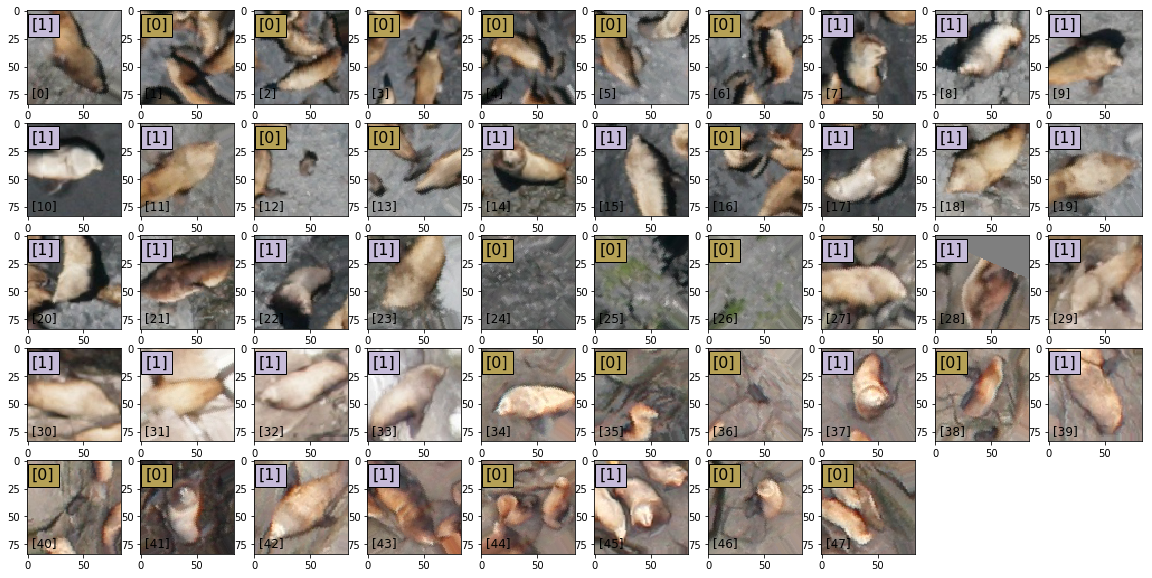

2017-06-11 01:49:49,117 INFO > [done]    generating image patches. rows=5; cols=10 (4276.266 ms)


In [5]:
#logger.info('INPUT DATASET DATA')
#dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
#with h5py.File(input_dataset_path, 'r') as h5file:
#    logger.info('generator')
#    input_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0.001, end_ratio=0.0012, batch_size=64)
#    X, Y = utils.dump_xy_to_array(input_generator.flow(), input_generator.size, x=True, y=True)
#    utils.show_images(X, image_labels=utils.onehot_to_label(Y), group_by_label=False, cols=10, is_bgr=True, size=2)
#
#    logger.info('x ' + str(np.shape(X)))
#    logger.info('y ' + str(np.shape(Y)))
#    logger.info(str(utils.class_distribution(Y)))

logger.info('BALANCE GENERATOR DATA')
#dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
X_train, Y_train = utils.dump_xy_to_array(train_generator.flow(), train_generator.size, x=False, y=True)
logger.info('y ' + str(np.shape(Y_train)))
#logger.info(str(utils.class_distribution(Y_train)))

for xs,ys in train_generator.flow():
    utils.show_images(xs, image_labels=ys, cols=10, is_bgr=True, size=2)
    break

### Prepare CNN model

In [6]:
logger.info('Load CNN model')
#model = lions.convnet_alexnet2_lion_keras(IMAGE_DIMS)

model = None
if(LOAD_MODEL_FILE!=None and os.path.isfile(LOAD_MODEL_FILE)):
    with open(LOAD_MODEL_FILE, 'r') as model_file:
        my = model_file.read()
        model = models.model_from_yaml(my)
        logger.info('loaded model from file ' + LOAD_MODEL_FILE)
else:
    model = lions.convnet_medium1_single(IMAGE_DIMS)
    logger.info('loaded model from function convnet_medium1_single')
    

if(LOAD_WEIGHTS_FILE!=None and os.path.isfile(LOAD_WEIGHTS_FILE)):
    model.load_weights(LOAD_WEIGHTS_FILE)
    logger.info('Loaded model weights from ' + LOAD_WEIGHTS_FILE)

logger.info('Model prepared')

2017-06-11 01:49:49,144 INFO Load CNN model
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:160: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), kernel_initializer="glorot_uniform", activation="relu", padding="same")`
  model.add(convolutional.Conv2D(64, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:162: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), kernel_initializer="glorot_uniform", activation="relu", padding="same")`
  model.add(convolutional.Conv2D(128, (3, 3), activation='relu', padding='same', init='glorot_uniform'))
/notebooks/datascience-snippets/kaggle-sea-lion/modules/lions.py:164: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3), kernel_initializer="glorot_uniform", activation="relu", padding="same")`
  model.add(convolutional.Conv2D(256, (3, 3), activation='relu', padding='same'

## Train model

In [7]:
if(RUN_TRAINING):
    logger.info('Starting CNN training...')
    history = model.fit_generator(train_generator.flow(),
                  steps_per_epoch = train_generator.nr_batches,
                  nb_epoch = TRAIN_EPOCHS,
                  callbacks = cnn.get_callbacks_keras(model, WEIGHTS_DIR, TF_LOGS_DIR),
                  validation_data = valid_generator.flow(), 
                  validation_steps = valid_generator.nr_batches,
                  verbose = 1)

    if(SAVE_MODEL_FILE!=None):
        with open(SAVE_MODEL_FILE, 'w') as model_file:
            model_file.write(model.to_yaml())
            logger.info('Saved last model to ' + SAVE_MODEL_FILE)
    
    if(SAVE_WEIGHTS_FILE!=None):
        model.save_weights(SAVE_WEIGHTS_FILE)
        logger.info('Saved last weights to ' + SAVE_WEIGHTS_FILE)


2017-06-11 01:49:49,269 INFO Starting CNN training...


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


2017-06-11 01:49:49,465 INFO Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


2017-06-11 01:49:49,470 INFO Summary name conv2d_1/kernel:0 is illegal; using conv2d_1/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


2017-06-11 01:49:49,475 INFO Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


INFO:tensorflow:Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


2017-06-11 01:49:49,481 INFO Summary name conv2d_1/bias:0 is illegal; using conv2d_1/bias_0 instead.


INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


2017-06-11 01:49:49,486 INFO Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


2017-06-11 01:49:49,492 INFO Summary name conv2d_2/kernel:0 is illegal; using conv2d_2/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


2017-06-11 01:49:49,495 INFO Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


INFO:tensorflow:Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


2017-06-11 01:49:49,502 INFO Summary name conv2d_2/bias:0 is illegal; using conv2d_2/bias_0 instead.


INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


2017-06-11 01:49:49,507 INFO Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


2017-06-11 01:49:49,512 INFO Summary name conv2d_3/kernel:0 is illegal; using conv2d_3/kernel_0 instead.


INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


2017-06-11 01:49:49,515 INFO Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


INFO:tensorflow:Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


2017-06-11 01:49:49,521 INFO Summary name conv2d_3/bias:0 is illegal; using conv2d_3/bias_0 instead.


INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


2017-06-11 01:49:49,527 INFO Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


INFO:tensorflow:Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


2017-06-11 01:49:49,537 INFO Summary name dense_1/kernel:0 is illegal; using dense_1/kernel_0 instead.


INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


2017-06-11 01:49:49,540 INFO Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


INFO:tensorflow:Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


2017-06-11 01:49:49,546 INFO Summary name dense_1/bias:0 is illegal; using dense_1/bias_0 instead.


INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


2017-06-11 01:49:49,551 INFO Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


INFO:tensorflow:Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


2017-06-11 01:49:49,557 INFO Summary name dense_2/kernel:0 is illegal; using dense_2/kernel_0 instead.


INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


2017-06-11 01:49:49,561 INFO Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


INFO:tensorflow:Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


2017-06-11 01:49:49,567 INFO Summary name dense_2/bias:0 is illegal; using dense_2/bias_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-06-11 01:49:49,571 INFO Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


2017-06-11 01:49:49,578 INFO Summary name dense_3/kernel:0 is illegal; using dense_3/kernel_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-06-11 01:49:49,581 INFO Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


INFO:tensorflow:Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.


2017-06-11 01:49:49,587 INFO Summary name dense_3/bias:0 is illegal; using dense_3/bias_0 instead.
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=3, validation_data=<generator..., callbacks=[<keras.ca..., epochs=20, validation_steps=1, verbose=1)`
2017-06-11 01:49:50,433 INFO starting new flow...


Epoch 1/20
Epoch 1/20
2/3 [===================>..........] - ETA: 2s - loss: 0.6948 - acc: 0.4687

2017-06-11 01:49:56,926 INFO starting new flow...


Epoch 00000: val_acc improved from -inf to 0.37500, saving model to ../../output/kaggle-sea-lion/07/weights/weights-00-0.38.h5
3/3 [==============================] - 9s - loss: 0.7835 - acc: 0.4931 - val_loss: 0.7420 - val_acc: 0.3750
Epoch 2/20
Epoch 2/20
3/3 [==============================] - 7s - loss: 0.7081 - acc: 0.4653 - val_loss: 0.6949 - val_acc: 0.3958
Epoch 3/20
Epoch 3/20
3/3 [==============================] - 8s - loss: 0.6869 - acc: 0.6181 - val_loss: 0.6963 - val_acc: 0.5208
Epoch 4/20
Epoch 4/20
3/3 [==============================] - 9s - loss: 0.6683 - acc: 0.7222 - val_loss: 0.7328 - val_acc: 0.5417
Epoch 5/20
Epoch 5/20
3/3 [==============================] - 6s - loss: 0.6291 - acc: 0.6597 - val_loss: 0.8338 - val_acc: 0.4792
Epoch 6/20
Epoch 6/20
3/3 [==============================] - 9s - loss: 0.5587 - acc: 0.7431 - val_loss: 0.6658 - val_acc: 0.6042
Epoch 7/20
Epoch 7/20
3/3 [==============================] - 8s - loss: 0.5063 - acc: 0.7708 - val_loss: 0.6104 - v

2017-06-11 01:52:20,814 INFO Saved last weights to ../../output/kaggle-sea-lion/07/last-weights-medium1-single.h5


### Epoch accuracy/loss

2017-06-11 01:52:20,827 INFO Training info


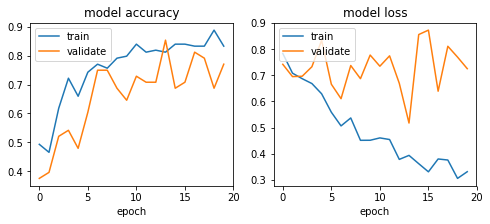

In [8]:
if(RUN_TRAINING):
    logger.info('Training info')
    cnn.show_training_info_keras(history)

### Confusion matrix

2017-06-11 01:52:21,154 INFO Evaluating model performance (26 samples)...
2017-06-11 01:52:21,158 INFO starting new flow...
2017-06-11 01:52:22,070 INFO Accuracy: 0.6875 - Loss: 0.61568570137
2017-06-11 01:52:22,072 INFO Predicting Y for detailed analysis...
/notebooks/datascience-snippets/kaggle-sea-lion/modules/cnn.py:59: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(self.y_ds==None):
2017-06-11 01:52:23,756 INFO Accuracy: 1.0
2017-06-11 01:52:23,759 INFO Number of test samples: 26
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:350: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
2017-06-11 01:52:23,761 INFO Kappa score: nan (-1 bad; 0 just luck; 1 great)
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no pr

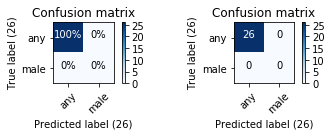

In [9]:
cnn.evaluate_dataset_keras(test_generator.flow(), 
                       test_generator.nr_batches, 
                       test_generator.size, 
                       model, 
                       class_labels=['any', 'male'])

2017-06-11 01:53:51,937 INFO > [started] generator dump...
2017-06-11 01:53:51,939 INFO starting new flow...


96/50

2017-06-11 01:53:52,172 INFO > [done]    generator dump (235.027 ms)
2017-06-11 01:53:52,747 INFO showing 50 images
2017-06-11 01:53:52,749 INFO > [started] generating image patches. rows=5; cols=12...


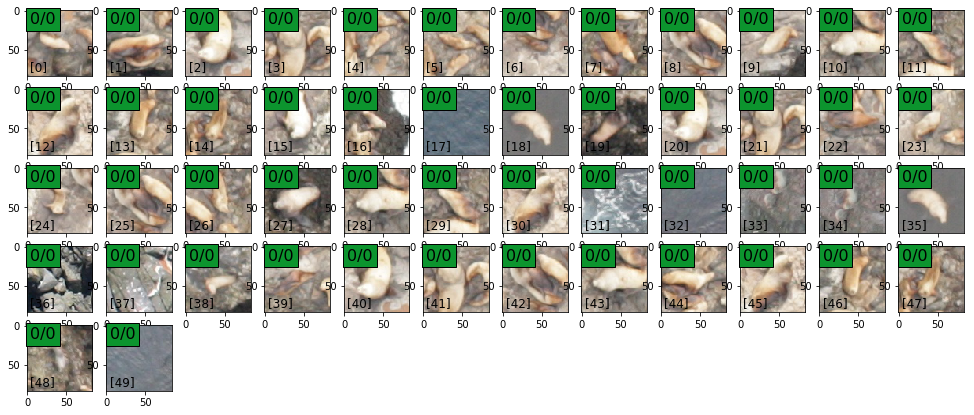

2017-06-11 01:53:57,071 INFO > [done]    generating image patches. rows=5; cols=12 (4322.084 ms)


In [11]:
a = test_generator.flow()
cnn.show_predictions(a, 50, model)